All done!


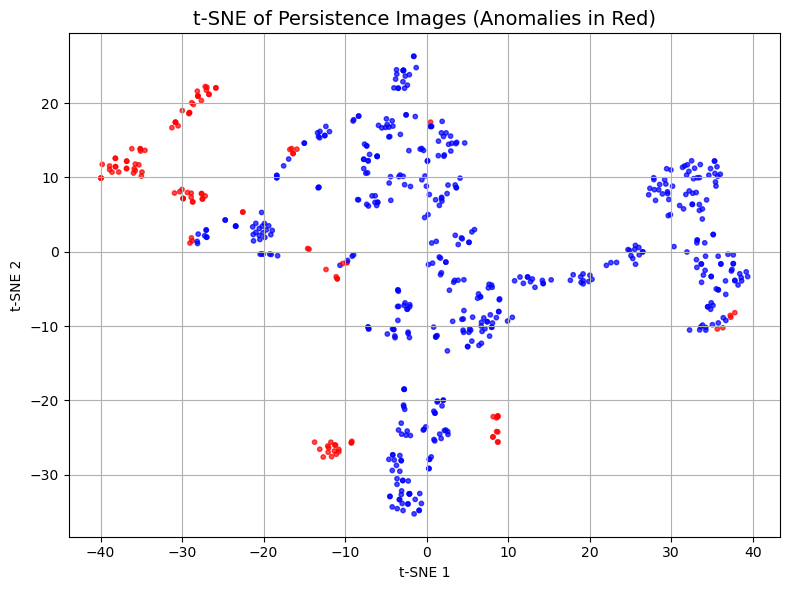

In [1]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import PersistenceImager
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Parameters
location = "Market St to 805 NB" 
window_size = 60
step = 1
embedding_dim = 3
embedding_tau = 5

# Load data
df = pd.read_csv("./dataset/Caltran/250414model_ready_output_final.csv")
df_loc = df[df['location'] == location]
df_valid = df_loc[df_loc['avg_speed'].notna()].reset_index(drop=True)
series = df_valid['avg_speed'].values
df_valid['timestamp'] = df_valid['time'].astype(str)
timestamps = df_valid['timestamp'].values

# Create sliding windows
windows = [series[i:i+window_size] for i in range(0, len(series) - window_size + 1, step)]
mid_indices = [i + window_size // 2 for i in range(0, len(timestamps) - window_size + 1, step)]
mid_timestamps = timestamps[mid_indices]

# TDA
def takens_embedding(x, dim=3, tau=5):
    return np.array([x[i:i + dim * tau:tau] for i in range(len(x) - (dim - 1) * tau)])

all_dgms_h1 = []
valid_windows = []
for w in windows:
    try:
        embedded = takens_embedding(w, dim=embedding_dim, tau=embedding_tau)
        dgms = ripser(embedded)['dgms']
        all_dgms_h1.append(dgms[1])
        valid_windows.append(dgms[1])
    except:
        all_dgms_h1.append(None)
        valid_windows.append(None)

# Fit PI
pimgr = PersistenceImager(pixel_size=0.5)
pimgr.fit([dgm for dgm in all_dgms_h1 if dgm is not None])

# Transform to PI vectors + entropy
records = []
for ts, dgm in zip(mid_timestamps, valid_windows):
    if dgm is not None:
        img = pimgr.transform(dgm)
        vec = img.flatten()
        score_entropy = entropy(vec / (np.sum(vec) + 1e-8))
    else:
        vec = np.zeros(100)
        score_entropy = 0.0
    record = {'timestamp': ts, 'complexity_entropy': score_entropy}
    record.update({f'f{i}': v for i, v in enumerate(vec)})
    records.append(record)

df_vineyard = pd.DataFrame(records)

# Top-k export
top_k = 20
df_topk = df_vineyard.sort_values(by="complexity_entropy", ascending=False).head(top_k)
df_topk.to_csv("top20_high_entropy_windows.csv", index=False)

# t-SNE visualization
X = df_vineyard.drop(columns=["timestamp", "complexity_entropy"]).values
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Anomaly detection
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_forest.fit(X)  # <<<<<<<< 
df_vineyard["anomaly_score"] = iso_forest.decision_function(X)
df_vineyard["is_anomaly"] = iso_forest.predict(X)

# Save full output
df_vineyard.to_csv("avg_speed_vineyard_with_entropy_and_anomaly.csv", index=False)

# Save t-SNE with anomaly plot
plt.figure(figsize=(8, 6))
colors = ['red' if x == -1 else 'blue' for x in df_vineyard["is_anomaly"]]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, alpha=0.7, c=colors)
plt.title("t-SNE of Persistence Images (Anomalies in Red)", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_with_anomalies.png", dpi=300)
# plt.close()

print("All done!")


### Visualization

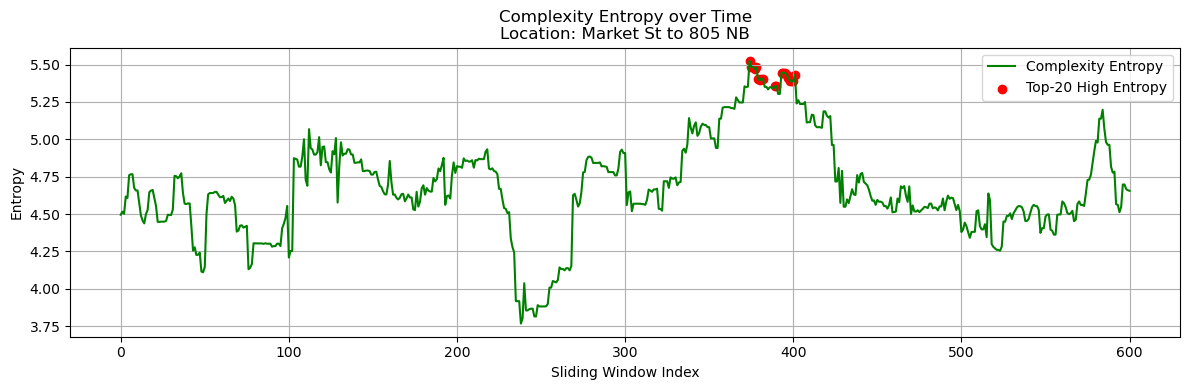

In [2]:
plt.figure(figsize=(12, 4))
plt.plot(df_vineyard['complexity_entropy'].values, label='Complexity Entropy', color='green')
plt.scatter(df_topk.index, df_topk['complexity_entropy'], color='red', label='Top-20 High Entropy')
plt.title(f"Complexity Entropy over Time\nLocation: {location}")
plt.xlabel("Sliding Window Index")
plt.ylabel("Entropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("entropy_timeseries.png", dpi=300)


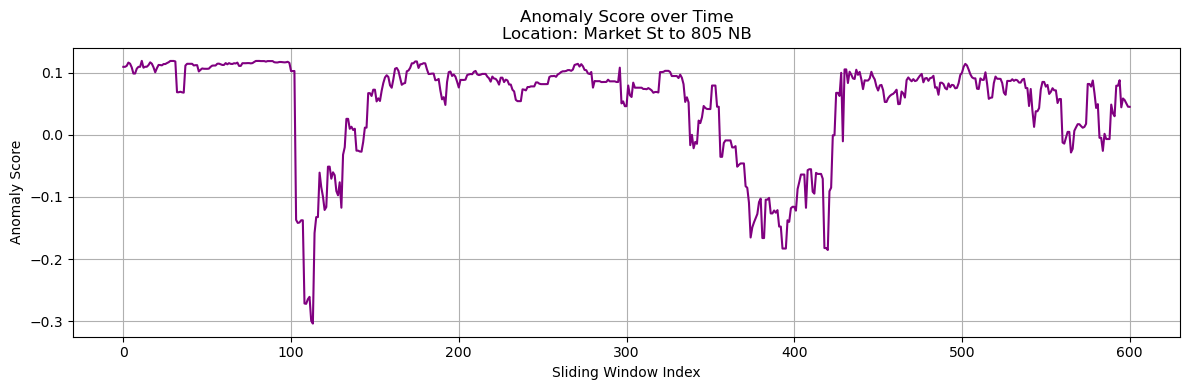

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(df_vineyard['anomaly_score'].values, label='Anomaly Score', color='purple')
plt.title(f"Anomaly Score over Time\nLocation: {location}")
plt.xlabel("Sliding Window Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("anomaly_score_timeseries.png", dpi=300)


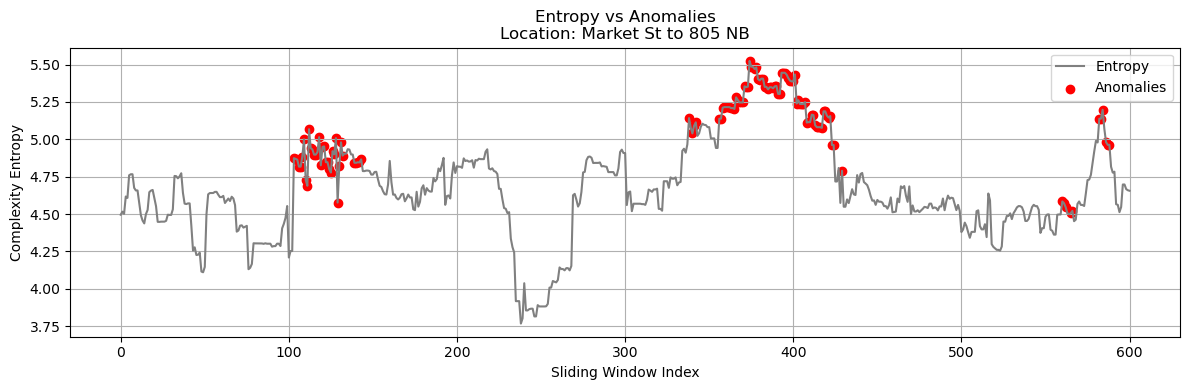

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df_vineyard['complexity_entropy'].values, label='Entropy', color='gray')
anomaly_indices = df_vineyard[df_vineyard['is_anomaly'] == -1].index
plt.scatter(anomaly_indices, df_vineyard.loc[anomaly_indices, 'complexity_entropy'], 
            color='red', label='Anomalies')
plt.title(f"Entropy vs Anomalies\nLocation: {location}")
plt.xlabel("Sliding Window Index")
plt.ylabel("Complexity Entropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("entropy_vs_anomaly.png", dpi=300)


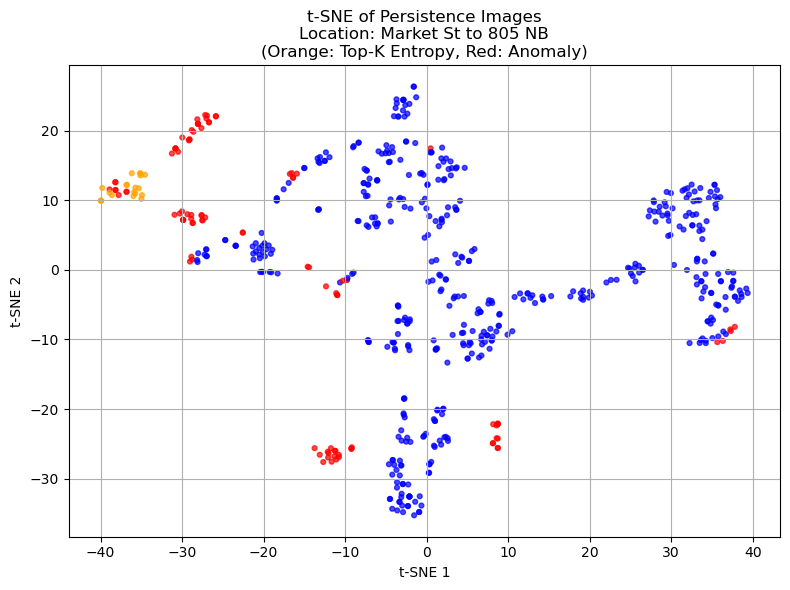

In [5]:
plt.figure(figsize=(8, 6))
topk_indices = df_vineyard.index.isin(df_topk.index)
colors = ['orange' if top else ('red' if a == -1 else 'blue') 
          for top, a in zip(topk_indices, df_vineyard["is_anomaly"])]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=12, alpha=0.7, c=colors)
plt.title(f"t-SNE of Persistence Images\nLocation: {location}\n(Orange: Top-K Entropy, Red: Anomaly)", fontsize=12)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_with_topk_entropy.png", dpi=300)


In [6]:
import pandas as pd
import numpy as np
from ripser import ripser
from persim import PersistenceImager
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# -----------------------------
# Parameters
# location = "Market St to 805 NB"
window_size = 60
step = 1
embedding_dim = 3
embedding_tau = 5
pixel_size = 0.5

# -----------------------------
# Load main traffic dataset
df = pd.read_csv("./dataset/Caltran/250414model_ready_output_final.csv")
df_loc = df[df['location'] == location].reset_index(drop=True)
df_loc['timestamp'] = df_loc['time'].astype(str)

# Compute avg_v from v1~v6
v_cols = [f'v{i}' for i in range(1, 7)]
df_loc['avg_v'] = df_loc[v_cols].replace(0, np.nan).mean(axis=1)

# Filter valid rows
df_valid = df_loc[df_loc['avg_v'].notna()].reset_index(drop=True)
series = df_valid['avg_v'].values
timestamps = df_valid['timestamp'].values

# -------------------------------------------------------
# 🧪 BASELINE MODEL (raw v1~v6 windows, no vineyard/avg_v)
v_series = df_valid[v_cols].values
baseline_windows = [v_series[i:i+window_size] for i in range(0, len(v_series) - window_size + 1, step)]
baseline_timestamps = [timestamps[i + window_size // 2] for i in range(0, len(timestamps) - window_size + 1, step)]

df_base = pd.DataFrame({
    'timestamp': baseline_timestamps,
    'X': baseline_windows
})

# Flatten feature vectors
df_base['X'] = df_base['X'].apply(lambda x: x.flatten())

# Load gold labels and merge
df_true = pd.read_csv("avg_speed_vineyard_with_entropy_and_anomaly.csv")
df_base['timestamp'] = df_base['timestamp'].astype(str)
df_true['timestamp'] = df_true['timestamp'].astype(str)
df_base = pd.merge(df_base, df_true[['timestamp', 'is_anomaly']], on='timestamp', how='inner')
df_base = df_base.dropna()

# Train baseline model
X_base = np.stack(df_base['X'].values)
y_base = df_base['is_anomaly'].values
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
clf_base = RandomForestClassifier(n_estimators=100, random_state=42)
clf_base.fit(Xb_train, yb_train)
yb_pred = clf_base.predict(Xb_test)

# Evaluate baseline
print("\n Baseline Classification Report (no avg_v / no vineyard):")
print(classification_report(yb_test, yb_pred, digits=4))
df_base['pred_baseline'] = clf_base.predict(X_base)
df_base.to_csv("baseline_rawv_supervised_result.csv", index=False)
print("Saved: baseline_rawv_supervised_result.csv")

# -------------------------------------------------------
# 🌿 Vineyard Feature Model (PI vectors from persistent homology)

# Create sliding windows of avg_v
windows = [series[i:i+window_size] for i in range(0, len(series) - window_size + 1, step)]
mid_indices = [i + window_size // 2 for i in range(0, len(timestamps) - window_size + 1, step)]
mid_timestamps = timestamps[mid_indices]

# Takens embedding
def takens_embedding(x, dim=3, tau=5):
    return np.array([x[i:i + dim * tau:tau] for i in range(len(x) - (dim - 1) * tau)])

# Compute persistence diagrams
all_dgms_h1 = []
for w in windows:
    try:
        embedded = takens_embedding(w, dim=embedding_dim, tau=embedding_tau)
        dgms = ripser(embedded)['dgms']
        all_dgms_h1.append(dgms[1])
    except:
        all_dgms_h1.append(None)

# Fit Persistence Imager
valid_diagrams = [dgm for dgm in all_dgms_h1 if dgm is not None and len(dgm) > 0]
pimgr = PersistenceImager(
    pixel_size=20.0,
    birth_range=(0, 50),
    pers_range=(0, 30)
)
pimgr.fit(valid_diagrams)
print("PI vector length:", pimgr.transform(valid_diagrams[0]).flatten().shape[0])

# Transform into PI vectors
records = []
for ts, dgm in zip(mid_timestamps, all_dgms_h1):
    record = {'timestamp': ts}
    if dgm is not None and len(dgm) > 0:
        vec = pimgr.transform(dgm).flatten()
    else:
        vec = np.zeros_like(pimgr.transform(valid_diagrams[0]).flatten())
    for i, v in enumerate(vec):
        record[f'f{i}'] = v
    records.append(record)

df_pi = pd.DataFrame(records)

# t-SNE visualization (optional)
X = df_pi.drop(columns=['timestamp']).values
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
df_pi['tsne1'], df_pi['tsne2'] = X_tsne[:, 0], X_tsne[:, 1]

# Merge with gold labels
df_pi['timestamp'] = df_pi['timestamp'].astype(str)
df_merged = pd.merge(df_pi, df_true[['timestamp', 'is_anomaly']], on='timestamp', how='inner').dropna()

# Train model on vineyard features
X_vine = df_merged[[col for col in df_merged.columns if col.startswith('f')]].values
y_vine = df_merged['is_anomaly'].values
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vine, y_vine, test_size=0.2, random_state=42)
clf_vine = RandomForestClassifier(n_estimators=100, random_state=42)
clf_vine.fit(Xv_train, yv_train)
yv_pred = clf_vine.predict(Xv_test)

# Evaluate vineyard model
print("\n Vineyard Classification Report (with PI features):")
print(classification_report(yv_test, yv_pred, digits=4))
df_merged['pred_supervised'] = clf_vine.predict(X_vine)
df_merged.to_csv("avg_v_vineyard_supervised_result.csv", index=False)
print(" Saved: avg_v_vineyard_supervised_result.csv")



 Baseline Classification Report (no avg_v / no vineyard):
              precision    recall  f1-score   support

          -1     0.3333    0.0417    0.0741        24
           1     0.8051    0.9794    0.8837        97

    accuracy                         0.7934       121
   macro avg     0.5692    0.5105    0.4789       121
weighted avg     0.7115    0.7934    0.7231       121

Saved: baseline_rawv_supervised_result.csv
PI vector length: 330

 Vineyard Classification Report (with PI features):
              precision    recall  f1-score   support

          -1     0.9130    0.8750    0.8936        24
           1     0.9694    0.9794    0.9744        97

    accuracy                         0.9587       121
   macro avg     0.9412    0.9272    0.9340       121
weighted avg     0.9582    0.9587    0.9583       121

 Saved: avg_v_vineyard_supervised_result.csv
